# Train additional models using fast.ai

Try out some different ideas for improving the results.

## Setup

### Import necessary libraries

In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import matplotlib.pyplot as plt #used to plot in notebook

from fastai.data.all import *
from fastai.data.external import *
from fastai.vision.all import *

import librosa;
import librosa.display;

import PIL as Pillow;

### Check if CUDA is available - This will be a problem later if this doesn't work

In [2]:
print(torch.cuda.is_available())

True


### Setup dataset paths

In [3]:
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
SAMPLE_DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'sample_data'))

DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')
path = Path(DATA_ROOT_DIR)

### Create Fast.AI Transformer to Load Audio to Spectrogram

In [5]:
# This code takes a single channel image (greyscale) and converts it into a 3-channel image (RGB)
# It also normalizes so that all values are between [0,255]
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

# Lots of libraries and methods for generating a spectrogram
# Under the hood all these algorithms rely on a Fast Fourier Transform
# Originally, I wanted to use torchaudio because that is CUDA enabled and can be accelerated on GPU
# Unfortunately, the shape of the data returned simply did not make any sense and working with tensors
# as opposed to numpy arrays was incredibly annoying. It just didn't work.
# I tried other libraries as well but ultimately settled on librosa since it seems the most widely used
# There exist fast.ai packages like fastaudio and other forks but like many open-source things they are unmaintained
# Using those type of packages breaks the dependencies and on my environment forced a non-CUDA
# accelerated version of pytorch which is useless
def create_spectrogram(file_path):
    samples, sample_rate = librosa.core.load(file_path, sr=2000)
    
    # the parameters here are tunable and are hard-coded to what i've found works well for this dataset
    n_fft=256
    hop_length=32
    win_length=192
    
    # Compute spectrogram, using some sensible defaults
    # Opportunities here to tweak possibly, just not sure how much it would help
    # We don't use Nicholas' settings as for some reason they get bad results with this library
    D = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    
    # Normalize to decibals
    S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_dB, sample_rate

# This is an alternative type of spectrogram.
# My understanding is that it normalizes the spectrogram based on what humans can perceive which is
# Settings here are open to tweaking
def create_mel_spectrogram(file_path):
    samples, sample_rate = librosa.core.load(file_path, sr=2000)
    
    # the parameters here are tunable and are hard-coded to what i've found works well for this dataset
    n_fft=256
    hop_length=32
    win_length=192
    fmax = 1000 # cut off at 1000Hz
    
    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, fmax=fmax, n_fft=n_fft, hop_length=hop_length, win_length=win_length, center=False)
    
    # Normalize to decibals
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sample_rate


# Converts a spectrogram (numpy) to a 3-channel (RGB) Fast.AI Image
def spectrogram_to_image(spec):
    
    # Most vision models in fast.ai use images with three channels (RGB)
    # spectrogram functions don't return images, they return data
    # plot libraries like matplotlib help us visualize the data as an image, but it is not an image
    # it is a multi-dimensional array-like object whose values can be positive or negative
    
    # We need to convert it from this format into a 3 channel (RGB) whose values are bounded between [0, 255]
    colored_np = mono_to_color(spec)
    
    # Pillow is a fork of PIL (standard Python image library), we consider Pillow.Image to be regular Python images
    # In order to use Pillow features like crop, we have to convert the image from numpy into PIL (Pillow)
    pillow_image = Pillow.Image.fromarray(colored_np) # convert to regular python image
    
    # When you manually convert a spectrogram to an image without using matplotlib you have to flip it vertically
    flipped_image = pillow_image.transpose(Image.FLIP_TOP_BOTTOM) # flip image
    
    # This will crop the image by taking from the height to make a square
    h, w, *other = pillow_image.shape
    cropped_image = flipped_image.crop((0, h-w, w, h))
    cropped_image_np = np.array(cropped_image) # back to numpy
        
    # Kinda confusing but fast.ai has a class called PILImage and so we convert our real PIL image into a fast.ai one
    fast_ai_image = PILImage.create(cropped_image_np)
    return fast_ai_image


# I chose to load the audio files directly into fast.ai using the DataBlock API.
# Alternatively, we could have pre-computed all the spectrograms in the 00_getting_started.ipynb but
# I decided against it because then it would be unlikely for anyone to actually make modifications to the images
# Writing 40,000 files to disk is painfully slow so you wouldn't even be able to get started quickly
# This method creates a transformer which can take paths to audio files and transform them into spectrogram images.
# If you do some research you will see lots of people doing pretty terrible things involving file.io because
# it is not easy to figure out how to turn a spectrogram into a 3-channel image and further how to get that
# into a fast.ai image. This solution is pretty clever because since it is all in-memory it is insanely fast and
# does not rely on any type of pre-computation.
class SpecgramTransform(Transform):
    def __init__(self): self.aug = create_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img)
        return image

# Alternative transformer for generating images of Mel Spectrograms
class MelSpecgramTransform(Transform):
    def __init__(self): self.aug = create_mel_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img)
        return image

    
# IGNORE: Unless you decide to use SpecgramTransform 
# We may need to crop images. If you use the SpecgramTransform, cropping will likely be required 
# to turn the image into a square.
# It could be reasonable to cut-off the image at frequencies we know a whale call couldn't exist
# Ultimately, images will need to be square I believe so they would need to get filled with something
# The reason I created this transform is because fast.ai doesn't give you a transformer for precision cropping
# You either crop and cut out the center or you don't crop at all
# This transformer lets you optionally crop from any direction and leaves sides alone that you don't specify crops for
class CropImageTransform(Transform):
    def __init__(self, left=None, upper=None, right=None, lower=None):
        print("test constructor")
        self.aug = self.__crop_image
        self.box = (left, upper, right, lower)
    
    def __compute_box(self, image):
        # get current dimensions of image
        # *other is because we don't know if we will receive two elements or more
        # we get two for a greyscale image, we get three for a RGB
        h, w, *other = image.shape
        
        #get desired crop entered by user
        left, upper, right, lower = self.box
        
        #don't crop sides that user didn't want cropped
        left = 0 if left is None else left
        upper = 0 if upper is None else upper
        right = w if right is None else right
        lower = h if lower is None else lower
        
        #save computed box
        self.box = (left, upper, right, lower)
        
    def __crop_image(self, image):
        print("test crop")

        self.__compute_box(image)
        print(self.box)
        image_cropped = image.crop(self.box)
        return image_cropped
        
    # this transformer works on PILImages (fast.ai)
    # this transfomer does not work on PIL.Image (Pillow/PIL)
    def encodes(self, image):
        print("encode")
        print(image)
        cropped_image = self.aug(image)
        return cropped_image

Check one file to see if data loaded correctly

<class 'fastai.vision.core.PILImage'>
Specgram Size: (118, 118)


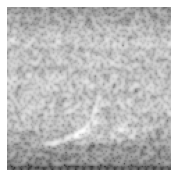

In [7]:
files = get_files(path)
audio_file = files[0]

spec, sample_rate = create_mel_spectrogram(audio_file)
spec_image = spectrogram_to_image(spec)
print(type(spec_image))
show_image(spec_image)

print(f"Specgram Size: {spec_image.shape}")

## Model Training

### Variation 1: _Describe the idea_

TODO: Write a brief description of what you are going to try differently.

In [ ]:
# load and transform data
dblock = DataBlock(
    blocks    = (TransformBlock, CategoryBlock),
    get_items = get_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = [ SpecgramTransform() ]
)
dls = dblock.dataloaders(path)

# train the model

### Variation 2: ...

## Results

Write up a summary of the results you achieved. Why do you suspect that certain things worked well? Why do you suspect other things didn't work so well? What did you learn? What surprised you? What, if any, would be additional next steps? What new questions do you have?